In [1]:
import cv2,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from poe.bulk.predictions import *
from itertools import groupby
from pathlib import Path 
from poe.bulk.image_cutter import *
import hashlib
from collections import defaultdict
import easyocr
from Levenshtein.StringMatcher import StringMatcher
from poe.ninja import retrieve_prices
from poe.valuation import own_valuations
from poe.div_cards.rules import *

display = pd.options.display

display.max_columns = 1000
display.max_rows = 1000
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
plt.style.use('dark_background')
%matplotlib inline

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [2]:
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
valuations=own_valuations()

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
https://poe.ninja/api/data/itemoverview Scarab 200
https://poe.ninja/api/data/currencyoverview Fragment 200
https://poe.ninja/api/data/currencyoverview Currency 200
https://poe.ninja/api/data/itemoverview Scarab 200
https://poe.ninja/api/data/itemoverview Oil 200
https://poe.ninja/api/data/itemoverview Fossil 200
https://poe.ninja/api/data/itemoverview Resonator 200
https://poe.ninja/api/data/itemoverview Prophecy 200
https://poe.ninja/api/data/itemoverview Incubator 200
https://poe.ninja/api/data/itemoverview UniqueMap 200
https://poe.ninja/api/data/itemoverview UniqueJewel 200
https://poe.ninja/api/data/itemoverview UniqueFlask 200
https://poe.ninja/api/data/itemoverview UniqueArmour 200
https://poe.ninja/api/data/itemoverview UniqueWeapon 200
https://poe.ninja/api/data/itemoverview UniqueAccessory 200
https://poe.ninja/api/data/itemoverview Essence 200
https://poe.ninja/api/data/itemover

In [3]:
def parse_numbers(img):
    assert img.shape[0]*img.shape[1]>0
    cols_of_interest=[1,6,8,11,13,14,19,21,24,26]

    try:
        frags=cut_image_to_frags(img)
    except Exception as e: 
        print(f'could not be processed:{e}')
        plt.figure(figsize=(20,20))
        plt.imshow(img)
        raise

    results=defaultdict(dict)
    for col in cols_of_interest:
        for row,frag in enumerate(frags[col]):
            _frag=normalize_frag(frag,target=(32,80))
#             plt.figure()
#             plt.imshow(_frag)
#             plt.show()
            result = predict_wrapper(_frag)
#             input(f'{result} next?')
            results[col][row]=result.replace('..','9.')
    return results
def parse_text(img,reader):
    assert img.shape[0]*img.shape[1]>0
    cols_of_interest=[4,17]
    try:
        frags=cut_image_to_frags(img)
    except Exception as e: 
        print(f'{path,img_hash} could not be processed:{e}')
        plt.figure(figsize=(20,20))
        plt.imshow(img)
        raise
    results=defaultdict(dict)
    for col in cols_of_interest:
        
        for row,frag in enumerate(frags[col]):
            result=reader.readtext(frag)
            if result:
                results[col][row]=result[0][1]
    return results

/Users/swozny/work/poe/venv/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,1,6,8,11,13,14,19,21,24,26
0,266,1,0.7,200.2,1.24,1,226.84,159.7,158.79,0.98
1,2,110,77,154,0.95,2,85,59.5,119,0.73
2,111,1,0.7,7777,0.48,2,45,31.5,63,0.39
3,1,75,52.5,52.5,0.32,1,60,42,42,0.26
4,59,1,0.7,41.3,0.25,2,28,19.6,39.2,0.24


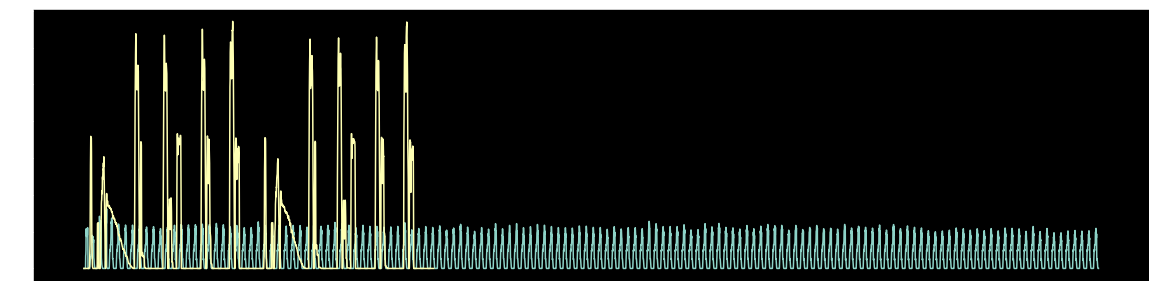

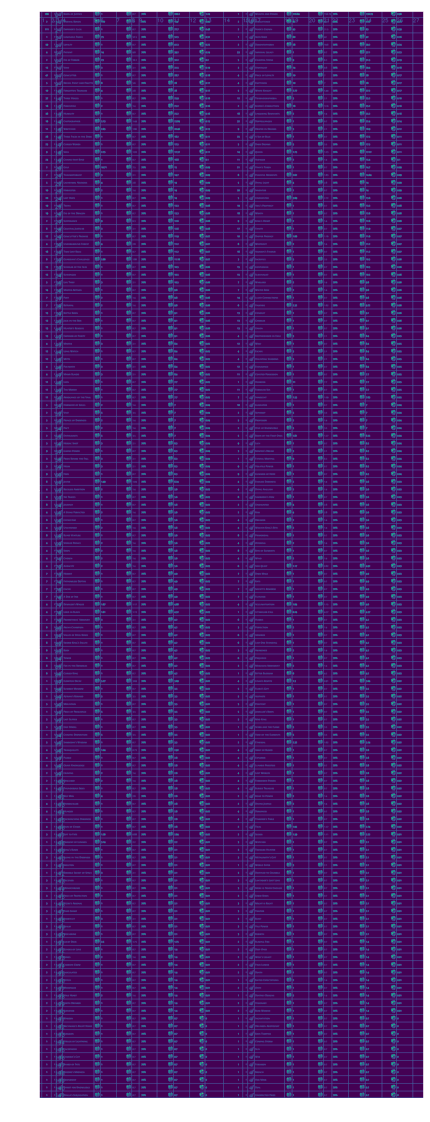

In [4]:
path='poe/bulk/data/tabs/unknown (32).png'

img=cv2.imread(path)
results=parse_numbers(img)
numbers=pd.DataFrame(results)
numbers.head()

,4,17
0,Boon of JusTIce,Wealth and Power
1,Eternal Bonds,Enlightened
2,Emperor $ Luck,Nook'$ Crown
3,Luminous Trove,Iron Bard
4,Loyalty,Dementophobia


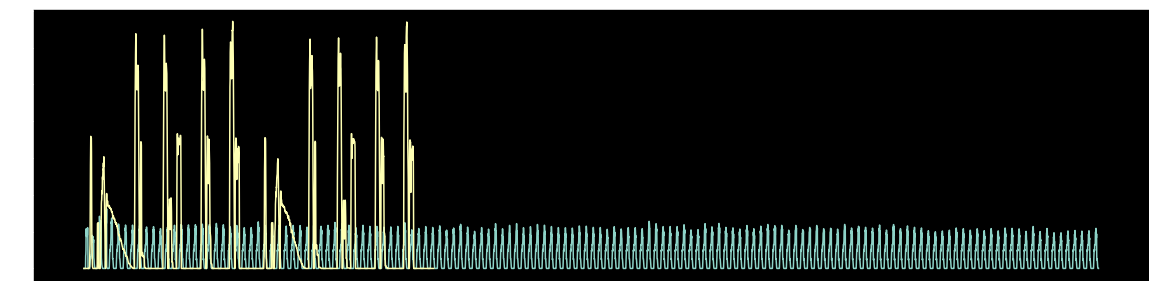

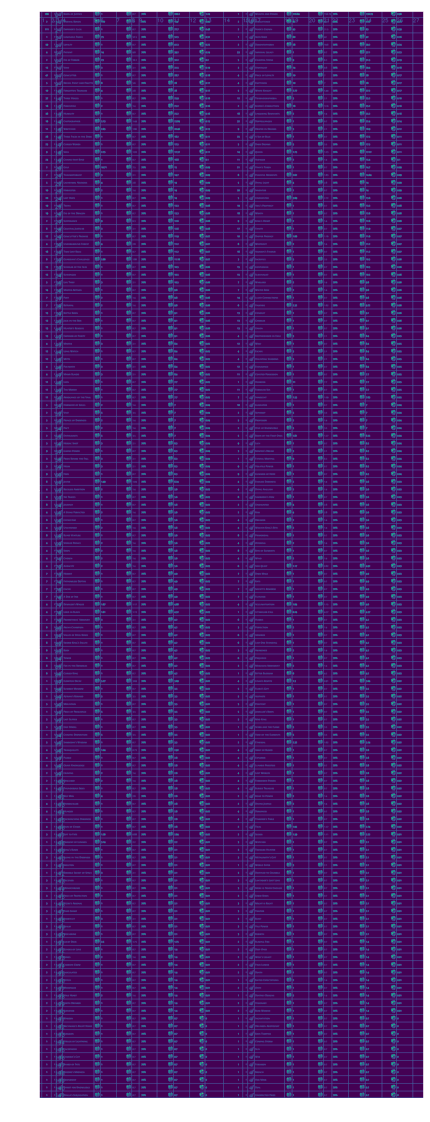

In [5]:
img=cv2.imread(path)
strings=pd.DataFrame(parse_text(img, reader))
strings.head()

In [6]:
prices=retrieve_prices()

https://poe.ninja/api/data/currencyoverview Fragment 200
https://poe.ninja/api/data/currencyoverview Currency 200
https://poe.ninja/api/data/itemoverview Scarab 200
https://poe.ninja/api/data/itemoverview Oil 200
https://poe.ninja/api/data/itemoverview Fossil 200
https://poe.ninja/api/data/itemoverview Resonator 200
https://poe.ninja/api/data/itemoverview Prophecy 200
https://poe.ninja/api/data/itemoverview Incubator 200
https://poe.ninja/api/data/itemoverview UniqueMap 200
https://poe.ninja/api/data/itemoverview UniqueJewel 200
https://poe.ninja/api/data/itemoverview UniqueFlask 200
https://poe.ninja/api/data/itemoverview UniqueArmour 200
https://poe.ninja/api/data/itemoverview UniqueWeapon 200
https://poe.ninja/api/data/itemoverview UniqueAccessory 200
https://poe.ninja/api/data/itemoverview Essence 200
https://poe.ninja/api/data/itemoverview DeliriumOrb 200
https://poe.ninja/api/data/itemoverview DivinationCard 200
https://poe.ninja/api/data/itemoverview Map 200
https://poe.ninja/ap

In [7]:

def map_read_to_ninja(read_from_picture, prices):
    
    raw=str(read_from_picture).lower()
    augmented=[f'the {raw}',f'{raw} scarab',raw]
    asd = max([(StringMatcher(seq1=candidate, seq2=str(y).lower()).ratio(), y, read_from_picture) for y in prices for candidate in augmented])[1]
    return asd
from functools import partial
strings_processed=strings.applymap(partial(map_read_to_ninja,prices=prices))
strings_processed.head()

,4,17
0,Boon of Justice,Wealth and Power
1,Eternal Bonds,The Enlightened
2,Emperor's Luck,Nook's Crown
3,Luminous Trove,The Iron Bard
4,Loyalty,Dementophobia


In [8]:
df=numbers.join(strings_processed)
df=df[sorted(df.columns)].rename({1:'quantity',4:'name',6:'price',8:'asking_price',11:'total_chaos',13:'total_exalt',14:'quantity',17:'name',19:'price',21:'asking_price',24:'total_chaos',26:'total_exalt'},axis=1)
left=df.iloc[:,int(len(df.columns)/2):]
right=df.iloc[:,:int(len(df.columns)/2)]
df=pd.concat([left,right],ignore_index=True,axis=0)
df=df[df.price!='']
df['total_chaos']=df.total_chaos.astype(float)
df=df.set_index('name').astype('float')
df['total_chaos']=df.quantity*df.asking_price
print(df['total_chaos'].sum())
df.head()

2951.66


,quantity,price,asking_price,total_chaos,total_exalt
name,,,,,
Wealth and Power,1.0,226.84,159.7,159.7,0.98
The Enlightened,2.0,85.00,59.5,119.0,0.73
Nook's Crown,2.0,45.00,31.5,63.0,0.39
The Iron Bard,1.0,60.00,42.0,42.0,0.26
Dementophobia,2.0,28.00,19.6,39.2,0.24


In [9]:
df['lookup']=df.index.map(xxxmap_div_card_name)
df=df.join(pd.Series(valuations,name='valuation'),on='lookup').drop(['lookup','total_exalt'],axis=1)
df['valuation']=df['valuation'].fillna(df.price)
df=df.drop(['price','total_chaos'],axis=1)
df.head()

,quantity,asking_price,valuation
name,,,
Wealth and Power,1.0,159.7,312.758182
The Enlightened,2.0,59.5,115.558333
Nook's Crown,2.0,31.5,45.000000
The Iron Bard,1.0,42.0,60.000000
Dementophobia,2.0,19.6,35.446411


In [21]:
df['own']=df.quantity*df.valuation
df['their']=df.quantity*df.asking_price
df['ratio']=df.their/df.own
df.sort_values('own',ascending=False).query('ratio<ratio.mean()')

,quantity,asking_price,valuation,own,their,ratio
name,,,,,,
Wealth and Power,1.0,159.70,312.758182,312.758182,159.70,0.510618
The Enlightened,2.0,59.50,115.558333,231.116667,119.00,0.514891
Eternal Bonds,2.0,77.00,110.000000,220.000000,154.00,0.700000
Emperor's Luck,111.0,0.70,1.523184,169.073373,77.70,0.459564
Nook's Crown,2.0,31.50,45.000000,90.000000,63.00,0.700000
The Eye of Terror,2.0,16.10,40.078947,80.157895,32.20,0.401707
Luminous Trove,1.0,52.50,75.000000,75.000000,52.50,0.700000
Dementophobia,2.0,19.60,35.446411,70.892823,39.20,0.552947
The Iron Bard,1.0,42.00,60.000000,60.000000,42.00,0.700000


In [11]:
print((df.quantity*df.valuation).sum())
(df.quantity*df.valuation).sort_values(ascending=False)

3399.1564528996714


name
Wealth and Power             312.758182
The Enlightened              231.116667
Eternal Bonds                220.000000
Emperor's Luck               169.073373
Nook's Crown                  90.000000
The Eye of Terror             80.157895
Luminous Trove                75.000000
Dementophobia                 70.892823
The Iron Bard                 60.000000
Loyalty                       59.000000
The Patient                   56.000000
The Void                      45.000000
The Celestial Stone           45.000000
The Strategist                42.000000
The Gemcutter                 41.000000
The Emptiness                 40.000000
The Price of Loyalty          40.000000
The Forgotten Treasure        40.000000
Brush, Paint and Palette      40.000000
The White Knight              38.850000
Triskaidekaphobia             36.000000
Keeper's Corruption           36.000000
The Porcupine                 36.000000
Humility                      36.000000
The Cartographer              34.08

In [24]:
(df.quantity*df.valuation-df.quantity*df.asking_price).sum()

447.4964528996711

In [23]:
(df.quantity*df.asking_price).sum()/(df.quantity*df.valuation).sum()

0.8683507337480945

In [13]:
valuations['The Artist']

KeyError: 'The Artist'

In [ ]:
df=df.set_index('name').join(scarab_values.set_index('name'),rsuffix='own')
(df.quantity.astype('float')*df.valuation.astype('float')).sum()

In [ ]:
 gems = [item for price in prices.values() for item in price if item["type"] == "SkillGem"]
relevant_gems = [
    gem
    for gem in gems
    if any(qual in gem["name"] for qual in ALT_QUALITY)
    if gem["variant"] == '20/20'
]
values = pd.Series({gem['name']:gem["chaosValue"] for gem in relevant_gems})